In [115]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import lightgbm as lgb
import pandas as pd

train = pd.read_csv('train.csv')
df_train = pd.read_csv('df_train.csv', index_col='row_id')
df_test = pd.read_csv('df_test.csv', index_col='row_id')
target_train = pd.read_csv('target_train.csv', index_col='row_id').squeeze()
target_test = pd.read_csv('target_test.csv', index_col='row_id').squeeze()

In [154]:
def smape_loss(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

def smape_cv(model, df_train, target_train):
    tscv = TimeSeriesSplit(n_splits=5)
    smape_list = []
    for _, (train_index, test_index) in enumerate(tscv.split(df_train), start=1):
        # Create training and validation datasets
        X_train = df_train.iloc[train_index]
        y_train = target_train.iloc[train_index]
        X_valid = df_train.iloc[test_index]
        y_valid = target_train.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='mae', verbose=False)

        # Make predictions
        y_pred = np.exp(model.predict(X_valid)) * X_valid['microbusiness_density']
        y_valid = np.exp(y_valid) * X_valid['microbusiness_density']

        # Calculate SMAPE score
        smape = smape_loss(y_valid, y_pred)
        smape_list.append(smape)
    
    print(f'Mean SMAPE: {np.mean(smape_list):.4f}')
    return smape_list  # Return the list of SMAPE scores

def lgbm_objective(trial, df_train, target_train):
    """
    Objective function for LightGBM optimization without rolling window cross-validation.
    """
    params = {
        'n_estimators'      : 200,
        'verbose'           : -1,
        'objective'         : 'regression_l1',
        'random_state'      : 42,
        'extra_trees'       : True,
        'colsample_bytree'  : trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'colsample_bynode'  : trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'max_depth'         : trial.suggest_int('max_depth', 3, 10),
        'learning_rate'     : trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'lambda_l1'         : trial.suggest_float('lambda_l1', 1e-2, 10.0),
        'lambda_l2'         : trial.suggest_float('lambda_l2', 1e-2, 10.0),
        'num_leaves'        : trial.suggest_int('num_leaves', 8, 1024),
        'min_data_in_leaf'  : trial.suggest_int('min_data_in_leaf', 5, 250),
        'early_stopping_round': 50,}

    model = lgb.LGBMRegressor(**params)
    score = smape_cv(model, df_train, target_train)
    return score

In [83]:
import optuna
import pandas as pd

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: lgbm_objective(trial, df_train, target_train), n_trials=20)

# Print the best trial
print(f"Best trial: {study.best_trial.value} with parameters {study.best_trial.params}")

[I 2023-04-16 15:29:10,921] A new study created in memory with name: no-name-4f4e9126-5e1a-44e5-a0f8-6c96314954dc
/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] lambda_l2 is set=8.557655850033877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.557655850033877
[LightGBM] [Warning] lambda_l1 is set=5.332976260266625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.332976260266625
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] lambda_l2 is set=8.557655850033877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.557655850033877
[LightGBM] [Warning] lambda_l1 is set=5.332976260266625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.332976260266625
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] lambda_l2 is set=8.557655850033877, reg_lambda=0.0 will be ignored. Current value

[I 2023-04-16 15:29:20,144] Trial 0 finished with value: 1.3867005402444628 and parameters: {'colsample_bytree': 0.553002222947216, 'colsample_bynode': 0.6040797025531345, 'max_depth': 4, 'learning_rate': 0.041224494401489606, 'lambda_l1': 5.332976260266625, 'lambda_l2': 8.557655850033877, 'num_leaves': 401, 'min_data_in_leaf': 141}. Best is trial 0 with value: 1.3867005402444628.


Mean SMAPE: 1.3867
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=9.529462321392966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.529462321392966
[LightGBM] [Warning] lambda_l1 is set=8.136915510971967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.136915510971967
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=9.529462321392966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.529462321392966
[LightGBM] [Warning] lambda_l1 is set=8.136915510971967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.136915510971967
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=9.529462321392966, reg_lambda=0.0 will be ignored. 

[I 2023-04-16 15:29:29,104] Trial 1 finished with value: 1.4087349792736104 and parameters: {'colsample_bytree': 0.6159104550761524, 'colsample_bynode': 0.49279947441462546, 'max_depth': 4, 'learning_rate': 0.010961774596736295, 'lambda_l1': 8.136915510971967, 'lambda_l2': 9.529462321392966, 'num_leaves': 215, 'min_data_in_leaf': 26}. Best is trial 0 with value: 1.3867005402444628.


Mean SMAPE: 1.4087
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] lambda_l2 is set=2.6817972982805975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6817972982805975
[LightGBM] [Warning] lambda_l1 is set=8.819438292081331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.819438292081331
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] lambda_l2 is set=2.6817972982805975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6817972982805975
[LightGBM] [Warning] lambda_l1 is set=8.819438292081331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.819438292081331
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] lambda_l2 is set=2.6817972982805975, reg_lambda=0.0 will be igno

[I 2023-04-16 15:29:48,353] Trial 2 finished with value: 1.371347158200798 and parameters: {'colsample_bytree': 0.9656046406793933, 'colsample_bynode': 0.37342269940841, 'max_depth': 7, 'learning_rate': 0.05254406818119492, 'lambda_l1': 8.819438292081331, 'lambda_l2': 2.6817972982805975, 'num_leaves': 1020, 'min_data_in_leaf': 28}. Best is trial 2 with value: 1.371347158200798.


Mean SMAPE: 1.3713
[LightGBM] [Warning] min_data_in_leaf is set=166, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=166
[LightGBM] [Warning] lambda_l2 is set=3.0944864501530445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0944864501530445
[LightGBM] [Warning] lambda_l1 is set=4.080218697524452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.080218697524452
[LightGBM] [Warning] min_data_in_leaf is set=166, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=166
[LightGBM] [Warning] lambda_l2 is set=3.0944864501530445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0944864501530445
[LightGBM] [Warning] lambda_l1 is set=4.080218697524452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.080218697524452
[LightGBM] [Warning] min_data_in_leaf is set=166, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=166
[LightGBM] [Warning] lambda_l2 is set=3.0944864501530445, reg_lambda=0.0 will b

[I 2023-04-16 15:30:02,951] Trial 3 finished with value: 1.3716261891652965 and parameters: {'colsample_bytree': 0.803980943522571, 'colsample_bynode': 0.7055229707333177, 'max_depth': 6, 'learning_rate': 0.04141464402774915, 'lambda_l1': 4.080218697524452, 'lambda_l2': 3.0944864501530445, 'num_leaves': 417, 'min_data_in_leaf': 166}. Best is trial 2 with value: 1.371347158200798.


Mean SMAPE: 1.3716
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Warning] lambda_l2 is set=0.5187837045921578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5187837045921578
[LightGBM] [Warning] lambda_l1 is set=2.1364880312658063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1364880312658063
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Warning] lambda_l2 is set=0.5187837045921578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5187837045921578
[LightGBM] [Warning] lambda_l1 is set=2.1364880312658063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1364880312658063
[LightGBM] [Warning] min_data_in_leaf is set=129, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=129
[LightGBM] [Warning] lambda_l2 is set=0.5187837045921578, reg_lambda=0.0 wi

[I 2023-04-16 15:30:08,110] Trial 4 finished with value: 1.4204139144303791 and parameters: {'colsample_bytree': 0.10862014198345742, 'colsample_bynode': 0.9414422486170887, 'max_depth': 3, 'learning_rate': 0.020594618035950342, 'lambda_l1': 2.1364880312658063, 'lambda_l2': 0.5187837045921578, 'num_leaves': 747, 'min_data_in_leaf': 129}. Best is trial 2 with value: 1.371347158200798.


Mean SMAPE: 1.4204
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] lambda_l2 is set=5.638550747840739, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.638550747840739
[LightGBM] [Warning] lambda_l1 is set=6.9965570259311995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.9965570259311995
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] lambda_l2 is set=5.638550747840739, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.638550747840739
[LightGBM] [Warning] lambda_l1 is set=6.9965570259311995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.9965570259311995
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] lambda_l2 is set=5.638550747840739, reg_lambda=0.0 will be

[I 2023-04-16 15:30:16,518] Trial 5 finished with value: 1.3849686827613545 and parameters: {'colsample_bytree': 0.7475522780751843, 'colsample_bynode': 0.8435496866083568, 'max_depth': 4, 'learning_rate': 0.03599791191783486, 'lambda_l1': 6.9965570259311995, 'lambda_l2': 5.638550747840739, 'num_leaves': 643, 'min_data_in_leaf': 101}. Best is trial 2 with value: 1.371347158200798.


Mean SMAPE: 1.3850
[LightGBM] [Warning] min_data_in_leaf is set=183, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=183
[LightGBM] [Warning] lambda_l2 is set=8.261479086385766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.261479086385766
[LightGBM] [Warning] lambda_l1 is set=4.5162005003683054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5162005003683054
[LightGBM] [Warning] min_data_in_leaf is set=183, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=183
[LightGBM] [Warning] lambda_l2 is set=8.261479086385766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.261479086385766
[LightGBM] [Warning] lambda_l1 is set=4.5162005003683054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5162005003683054
[LightGBM] [Warning] min_data_in_leaf is set=183, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=183
[LightGBM] [Warning] lambda_l2 is set=8.261479086385766, reg_lambda=0.0 will be

[I 2023-04-16 15:30:29,994] Trial 6 finished with value: 1.4021364704639916 and parameters: {'colsample_bytree': 0.1120884094330698, 'colsample_bynode': 0.9346501125125822, 'max_depth': 9, 'learning_rate': 0.018079011892194075, 'lambda_l1': 4.5162005003683054, 'lambda_l2': 8.261479086385766, 'num_leaves': 471, 'min_data_in_leaf': 183}. Best is trial 2 with value: 1.371347158200798.


Mean SMAPE: 1.4021
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] lambda_l2 is set=2.873488984017332, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.873488984017332
[LightGBM] [Warning] lambda_l1 is set=4.651093389515792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.651093389515792
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] lambda_l2 is set=2.873488984017332, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.873488984017332
[LightGBM] [Warning] lambda_l1 is set=4.651093389515792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.651093389515792
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] lambda_l2 is set=2.873488984017332, reg_lambda=0.0 will be ignored. 

[I 2023-04-16 15:30:56,186] Trial 7 finished with value: 1.3729821105700197 and parameters: {'colsample_bytree': 0.369354042917342, 'colsample_bynode': 0.39201062999563907, 'max_depth': 10, 'learning_rate': 0.0826944710704464, 'lambda_l1': 4.651093389515792, 'lambda_l2': 2.873488984017332, 'num_leaves': 974, 'min_data_in_leaf': 25}. Best is trial 2 with value: 1.371347158200798.


Mean SMAPE: 1.3730
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] lambda_l2 is set=4.412553737049126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.412553737049126
[LightGBM] [Warning] lambda_l1 is set=7.600047151786175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.600047151786175
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] lambda_l2 is set=4.412553737049126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.412553737049126
[LightGBM] [Warning] lambda_l1 is set=7.600047151786175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.600047151786175
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] lambda_l2 is set=4.412553737049126, reg_lambda=0.0 will be ignored. 

[I 2023-04-16 15:31:15,791] Trial 8 finished with value: 1.3719137759900786 and parameters: {'colsample_bytree': 0.6677402460537932, 'colsample_bynode': 0.4455369361013488, 'max_depth': 8, 'learning_rate': 0.07640916452985398, 'lambda_l1': 7.600047151786175, 'lambda_l2': 4.412553737049126, 'num_leaves': 66, 'min_data_in_leaf': 77}. Best is trial 2 with value: 1.371347158200798.


Mean SMAPE: 1.3719
[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] lambda_l2 is set=4.6494774300429444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6494774300429444
[LightGBM] [Warning] lambda_l1 is set=9.351817721148633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.351817721148633
[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] lambda_l2 is set=4.6494774300429444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6494774300429444
[LightGBM] [Warning] lambda_l1 is set=9.351817721148633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.351817721148633
[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] lambda_l2 is set=4.6494774300429444, reg_lambda=0.0 will b

[I 2023-04-16 15:31:37,706] Trial 9 finished with value: 1.3728120692348642 and parameters: {'colsample_bytree': 0.589221014827991, 'colsample_bynode': 0.7053814507754873, 'max_depth': 9, 'learning_rate': 0.03190194378449411, 'lambda_l1': 9.351817721148633, 'lambda_l2': 4.6494774300429444, 'num_leaves': 78, 'min_data_in_leaf': 188}. Best is trial 2 with value: 1.371347158200798.


Mean SMAPE: 1.3728
[LightGBM] [Warning] min_data_in_leaf is set=237, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=237
[LightGBM] [Warning] lambda_l2 is set=0.3706955928544202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3706955928544202
[LightGBM] [Warning] lambda_l1 is set=9.993245151194394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.993245151194394
[LightGBM] [Warning] min_data_in_leaf is set=237, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=237
[LightGBM] [Warning] lambda_l2 is set=0.3706955928544202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3706955928544202
[LightGBM] [Warning] lambda_l1 is set=9.993245151194394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.993245151194394
[LightGBM] [Warning] min_data_in_leaf is set=237, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=237
[LightGBM] [Warning] lambda_l2 is set=0.3706955928544202, reg_lambda=0.0 will b

[I 2023-04-16 15:31:51,599] Trial 10 finished with value: 1.3784404839801114 and parameters: {'colsample_bytree': 0.9355658311097798, 'colsample_bynode': 0.20262445390267042, 'max_depth': 6, 'learning_rate': 0.05936792015581657, 'lambda_l1': 9.993245151194394, 'lambda_l2': 0.3706955928544202, 'num_leaves': 1017, 'min_data_in_leaf': 237}. Best is trial 2 with value: 1.371347158200798.


Mean SMAPE: 1.3784
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] lambda_l2 is set=2.1339161486463385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1339161486463385
[LightGBM] [Warning] lambda_l1 is set=1.946554657915407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.946554657915407
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] lambda_l2 is set=2.1339161486463385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1339161486463385
[LightGBM] [Warning] lambda_l1 is set=1.946554657915407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.946554657915407
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] lambda_l2 is set=2.1339161486463385, reg_lambda=0.0 will be igno

[I 2023-04-16 15:32:06,287] Trial 11 finished with value: 1.3701413335704165 and parameters: {'colsample_bytree': 0.9864052494026941, 'colsample_bynode': 0.6891627886648479, 'max_depth': 6, 'learning_rate': 0.0524256187459706, 'lambda_l1': 1.946554657915407, 'lambda_l2': 2.1339161486463385, 'num_leaves': 759, 'min_data_in_leaf': 68}. Best is trial 11 with value: 1.3701413335704165.


Mean SMAPE: 1.3701
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] lambda_l2 is set=1.7718303522587218, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7718303522587218
[LightGBM] [Warning] lambda_l1 is set=0.12072415878496567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12072415878496567
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] lambda_l2 is set=1.7718303522587218, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7718303522587218
[LightGBM] [Warning] lambda_l1 is set=0.12072415878496567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12072415878496567
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] lambda_l2 is set=1.7718303522587218, reg_lambda=0.0 will

[I 2023-04-16 15:32:26,127] Trial 12 finished with value: 1.369994839547605 and parameters: {'colsample_bytree': 0.9949685337343414, 'colsample_bynode': 0.3040733029116425, 'max_depth': 7, 'learning_rate': 0.0550387931070483, 'lambda_l1': 0.12072415878496567, 'lambda_l2': 1.7718303522587218, 'num_leaves': 819, 'min_data_in_leaf': 61}. Best is trial 12 with value: 1.369994839547605.


Mean SMAPE: 1.3700
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l2 is set=1.3092319191606003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3092319191606003
[LightGBM] [Warning] lambda_l1 is set=0.19910171907005203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19910171907005203
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l2 is set=1.3092319191606003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3092319191606003
[LightGBM] [Warning] lambda_l1 is set=0.19910171907005203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19910171907005203
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l2 is set=1.3092319191606003, reg_lambda=0.0 will

[I 2023-04-16 15:32:47,337] Trial 13 finished with value: 1.373620568515033 and parameters: {'colsample_bytree': 0.9559964395731539, 'colsample_bynode': 0.12783240255611245, 'max_depth': 7, 'learning_rate': 0.09246605105406223, 'lambda_l1': 0.19910171907005203, 'lambda_l2': 1.3092319191606003, 'num_leaves': 786, 'min_data_in_leaf': 67}. Best is trial 12 with value: 1.369994839547605.


Mean SMAPE: 1.3736
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l2 is set=1.8431688165539222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8431688165539222
[LightGBM] [Warning] lambda_l1 is set=0.3911254241595774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3911254241595774
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l2 is set=1.8431688165539222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8431688165539222
[LightGBM] [Warning] lambda_l1 is set=0.3911254241595774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3911254241595774
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l2 is set=1.8431688165539222, reg_lambda=0.0 will be 

[I 2023-04-16 15:33:00,090] Trial 14 finished with value: 1.3781703051962768 and parameters: {'colsample_bytree': 0.8479200962915624, 'colsample_bynode': 0.2782986667206414, 'max_depth': 5, 'learning_rate': 0.05981024492644911, 'lambda_l1': 0.3911254241595774, 'lambda_l2': 1.8431688165539222, 'num_leaves': 807, 'min_data_in_leaf': 67}. Best is trial 12 with value: 1.369994839547605.


Mean SMAPE: 1.3782
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] lambda_l2 is set=0.13105751323980375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13105751323980375
[LightGBM] [Warning] lambda_l1 is set=1.7212742039135387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7212742039135387
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] lambda_l2 is set=0.13105751323980375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13105751323980375
[LightGBM] [Warning] lambda_l1 is set=1.7212742039135387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7212742039135387
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] lambda_l2 is set=0.13105751323980375, reg_lambda=0.0 wil

[I 2023-04-16 15:33:22,676] Trial 15 finished with value: 1.3683001223008333 and parameters: {'colsample_bytree': 0.9784110046610133, 'colsample_bynode': 0.562184028169755, 'max_depth': 8, 'learning_rate': 0.099305867998172, 'lambda_l1': 1.7212742039135387, 'lambda_l2': 0.13105751323980375, 'num_leaves': 621, 'min_data_in_leaf': 90}. Best is trial 15 with value: 1.3683001223008333.


Mean SMAPE: 1.3683
[LightGBM] [Warning] min_data_in_leaf is set=102, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=102
[LightGBM] [Warning] lambda_l2 is set=0.11803021474125527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11803021474125527
[LightGBM] [Warning] lambda_l1 is set=1.5395421385767343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5395421385767343
[LightGBM] [Warning] min_data_in_leaf is set=102, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=102
[LightGBM] [Warning] lambda_l2 is set=0.11803021474125527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11803021474125527
[LightGBM] [Warning] lambda_l1 is set=1.5395421385767343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5395421385767343
[LightGBM] [Warning] min_data_in_leaf is set=102, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=102
[LightGBM] [Warning] lambda_l2 is set=0.11803021474125527, reg_lambda=0

[I 2023-04-16 15:33:46,261] Trial 16 finished with value: 1.3703846151573091 and parameters: {'colsample_bytree': 0.8295548233844059, 'colsample_bynode': 0.3318050063457435, 'max_depth': 8, 'learning_rate': 0.09987378081472222, 'lambda_l1': 1.5395421385767343, 'lambda_l2': 0.11803021474125527, 'num_leaves': 586, 'min_data_in_leaf': 102}. Best is trial 15 with value: 1.3683001223008333.


Mean SMAPE: 1.3704
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] lambda_l2 is set=1.2386041228951283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2386041228951283
[LightGBM] [Warning] lambda_l1 is set=3.1476210454432834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1476210454432834
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] lambda_l2 is set=1.2386041228951283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2386041228951283
[LightGBM] [Warning] lambda_l1 is set=3.1476210454432834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1476210454432834
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] lambda_l2 is set=1.2386041228951283, reg_lambda=0.0 wi

[I 2023-04-16 15:34:13,876] Trial 17 finished with value: 1.3683385947820703 and parameters: {'colsample_bytree': 0.8899538467124427, 'colsample_bynode': 0.523535979842352, 'max_depth': 8, 'learning_rate': 0.06612496438536014, 'lambda_l1': 3.1476210454432834, 'lambda_l2': 1.2386041228951283, 'num_leaves': 871, 'min_data_in_leaf': 109}. Best is trial 15 with value: 1.3683001223008333.


Mean SMAPE: 1.3683
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] lambda_l2 is set=0.9816586550679153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9816586550679153
[LightGBM] [Warning] lambda_l1 is set=3.0437674209015952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0437674209015952
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] lambda_l2 is set=0.9816586550679153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9816586550679153
[LightGBM] [Warning] lambda_l1 is set=3.0437674209015952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0437674209015952
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] lambda_l2 is set=0.9816586550679153, reg_lambda=0.0 wi

[I 2023-04-16 15:35:12,178] Trial 18 finished with value: 1.368745537997592 and parameters: {'colsample_bytree': 0.7325784430444696, 'colsample_bynode': 0.5516895915914654, 'max_depth': 10, 'learning_rate': 0.07334834393578597, 'lambda_l1': 3.0437674209015952, 'lambda_l2': 0.9816586550679153, 'num_leaves': 890, 'min_data_in_leaf': 101}. Best is trial 15 with value: 1.3683001223008333.


Mean SMAPE: 1.3687
[LightGBM] [Warning] min_data_in_leaf is set=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] lambda_l2 is set=0.32071525110587806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.32071525110587806
[LightGBM] [Warning] lambda_l1 is set=3.2312668476820345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2312668476820345
[LightGBM] [Warning] min_data_in_leaf is set=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] lambda_l2 is set=0.32071525110587806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.32071525110587806
[LightGBM] [Warning] lambda_l1 is set=3.2312668476820345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2312668476820345
[LightGBM] [Warning] min_data_in_leaf is set=152, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=152
[LightGBM] [Warning] lambda_l2 is set=0.32071525110587806, reg_lambda=0

[I 2023-04-16 15:35:46,338] Trial 19 finished with value: 1.3692406279042253 and parameters: {'colsample_bytree': 0.8784463213241208, 'colsample_bynode': 0.48779970335084066, 'max_depth': 8, 'learning_rate': 0.09692931198011369, 'lambda_l1': 3.2312668476820345, 'lambda_l2': 0.32071525110587806, 'num_leaves': 617, 'min_data_in_leaf': 152}. Best is trial 15 with value: 1.3683001223008333.


Mean SMAPE: 1.3692
Best trial: 1.3683001223008333 with parameters {'colsample_bytree': 0.9784110046610133, 'colsample_bynode': 0.562184028169755, 'max_depth': 8, 'learning_rate': 0.099305867998172, 'lambda_l1': 1.7212742039135387, 'lambda_l2': 0.13105751323980375, 'num_leaves': 621, 'min_data_in_leaf': 90}


In [116]:
params = study.best_trial.params
LGBM = lgb.LGBMRegressor(**params)

In [157]:
smape_losses = smape_cv(LGBM, df_train, target_train)

/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] lambda_l1 is set=1.7212742039135387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7212742039135387
[LightGBM] [Warning] lambda_l2 is set=0.13105751323980375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13105751323980375
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] lambda_l1 is set=1.7212742039135387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7212742039135387
[LightGBM] [Warning] lambda_l2 is set=0.13105751323980375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13105751323980375
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] lambda_l1 is set=1.7212742039135387, reg_alpha=0.0 will be ignored. Current

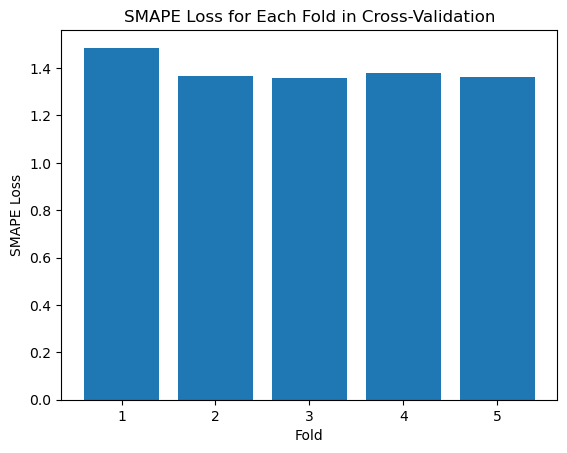

In [158]:
import matplotlib.pyplot as plt

plt.bar(range(1, len(smape_losses) + 1), smape_losses)

# Customize the plot
plt.xlabel('Fold')
plt.ylabel('SMAPE Loss')
plt.title('SMAPE Loss for Each Fold in Cross-Validation')
plt.xticks(range(1, len(smape_losses) + 1))

# Save the plot to a file
plt.savefig('smape_loss_per_fold.png')

# Display the plot
plt.show()

In [155]:
# from lightgbm import plot_importance
# import matplotlib.pyplot as plt
# y_pred = np.exp(LGBM.predict(df_test)) * df_test.microbusiness_density
# lgb.plot_metric(LGBM)

In [118]:
y_pred

row_id
1001_2022-06-01      3.352907
1003_2022-06-01      8.543238
1005_2022-06-01      1.192708
1007_2022-06-01      1.281455
1009_2022-06-01      1.777990
                      ...    
56037_2022-06-01     2.790848
56039_2022-06-01    25.721974
56041_2022-06-01     3.896313
56043_2022-06-01     3.128537
56045_2022-06-01     1.800259
Name: microbusiness_density, Length: 3085, dtype: float64

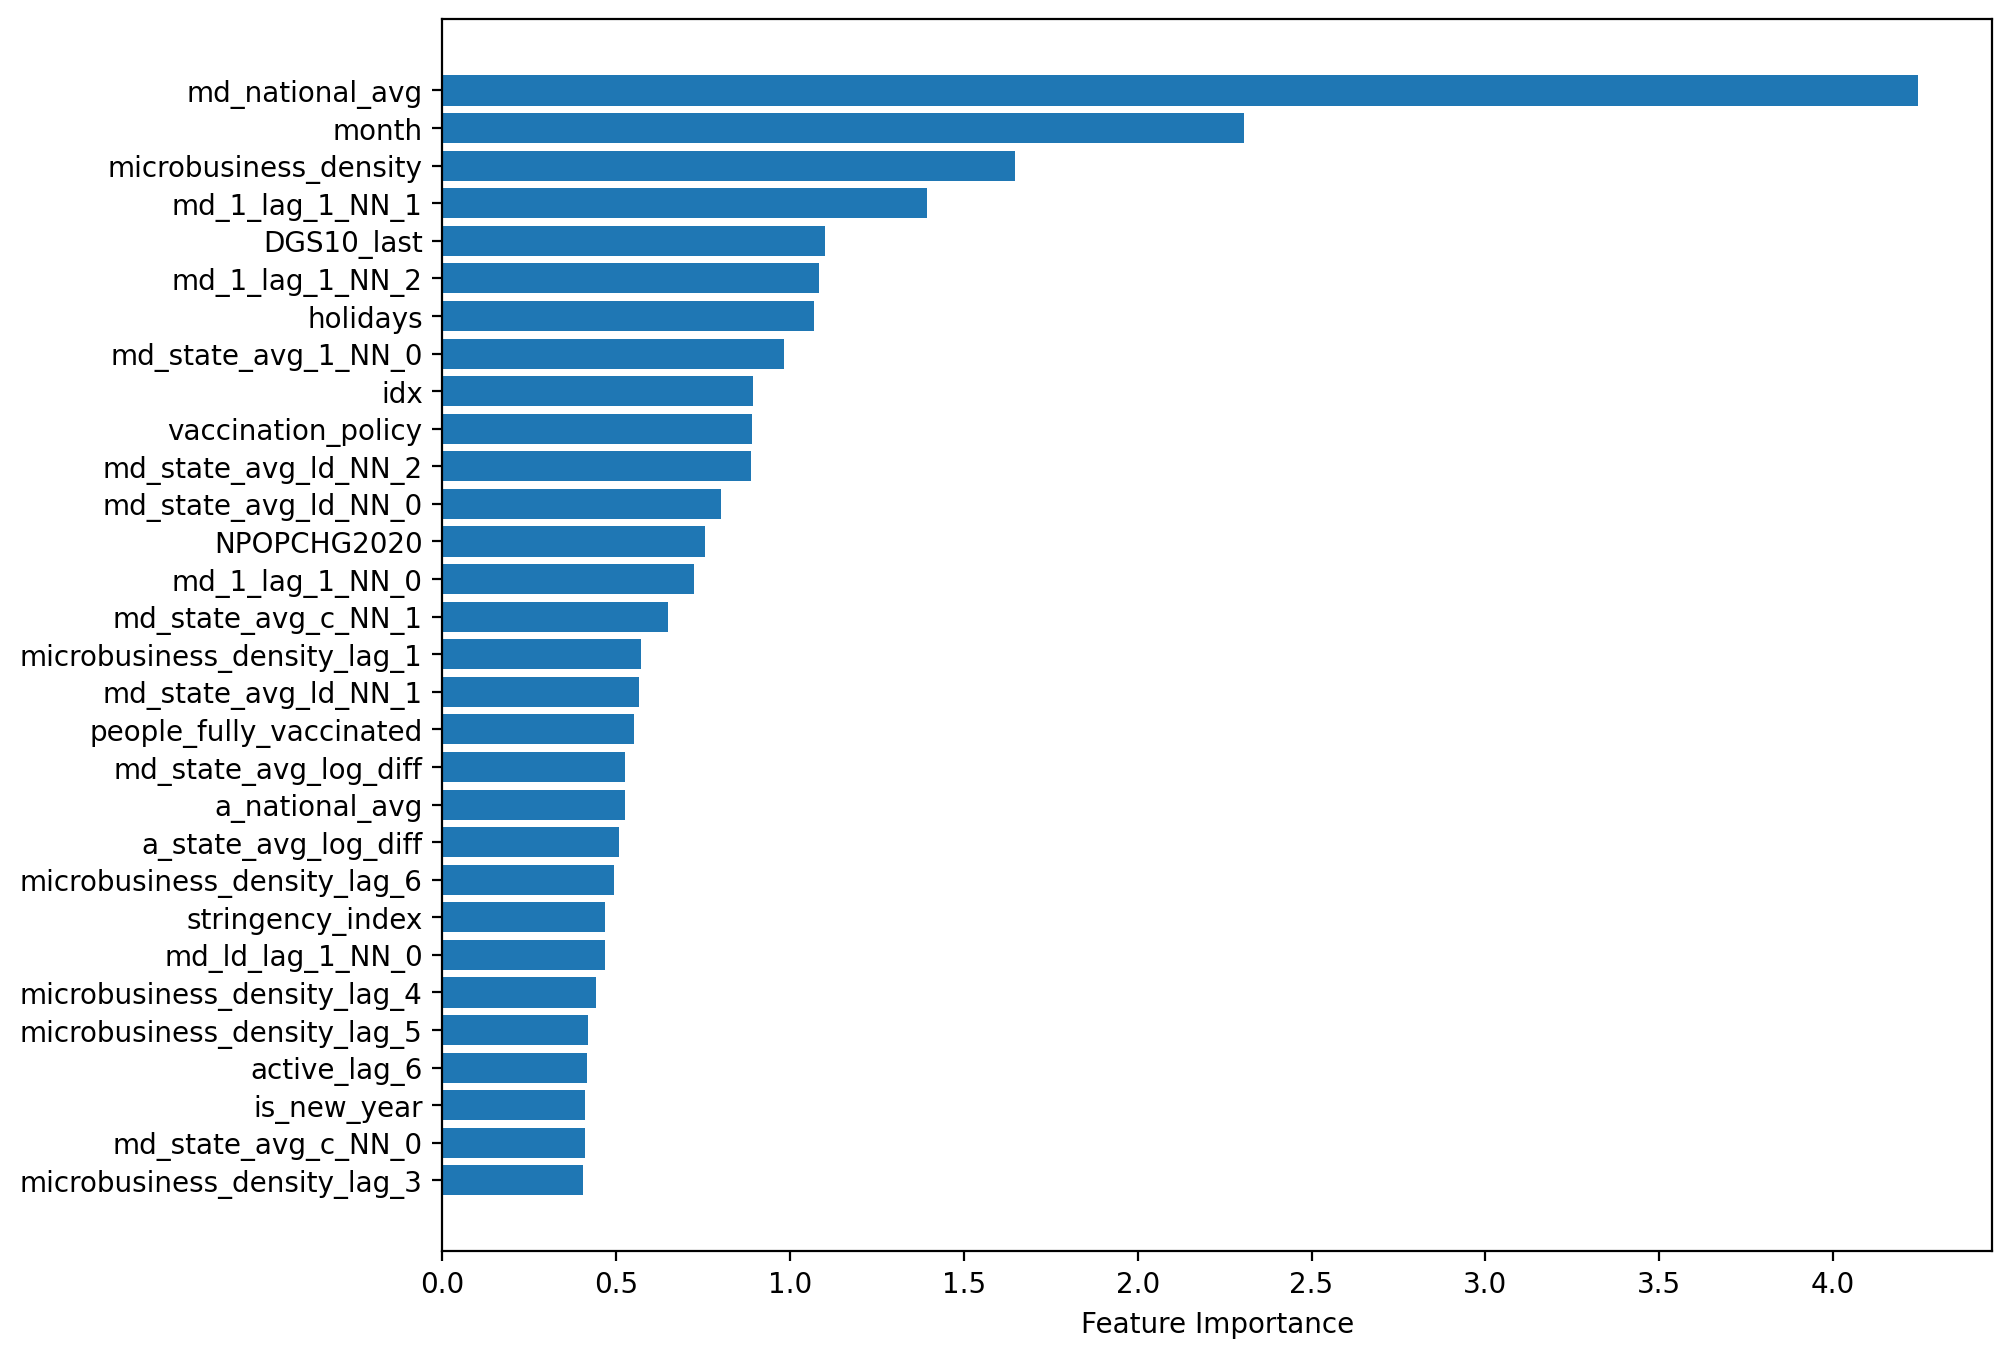

In [160]:
def plot_importance_top_n(model, figsize=(10, 9), top_n=30):
    feature_importance = model.booster_.feature_importance(importance_type='gain')
    features = model.feature_name_
    sorted_idx = np.argsort(feature_importance)[-top_n:]
    
    plt.figure(figsize=figsize, dpi=200)
    plt.barh(range(top_n), feature_importance[sorted_idx], align='center')
    plt.yticks(range(top_n), [features[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.show()

plot_importance_top_n(LGBM, figsize=(10, 8), top_n=30)

In [148]:
importances = LGBM.feature_importances_
from sklearn.feature_selection import SelectFromModel

def find_best_k(df_train, target_train, df_test, train, params):
    best_k = None
    best_smape = np.inf
    best_selected_features = None 
    
    LGBM = lgb.LGBMRegressor(**params)
    LGBM.fit(df_train, target_train)
    
    importances = LGBM.feature_importances_
    
    for k in range(10, 20):
        selector = SelectFromModel(LGBM, max_features=k, threshold=-np.inf)
        selector.fit(df_train, target_train)
        
        df_train_selected = selector.transform(df_train)
        df_test_selected = selector.transform(df_test)
        
        selected_features = df_train.columns[selector.get_support()]
        
        LGBM_selected = lgb.LGBMRegressor(**params)
        LGBM_selected.fit(df_train_selected, target_train)
        y_pred_selected = np.exp(LGBM_selected.predict(df_test_selected)) * df_test.microbusiness_density
        
        my_cfips = df_train['cfips'].unique()
        train_filtered = train[train.cfips.isin(my_cfips)]
        y_true = train_filtered[train_filtered.row_id.str.contains('2022-07-01')].microbusiness_density.values
        
        smape = smape_loss(y_true, y_pred_selected.values)
        
        if smape < best_smape:
            best_smape = smape
            best_k = k
            best_selected_features = selected_features
    
    return best_k, best_selected_features, best_smape

best_k, best_selected_features, best_smape = find_best_k(df_train, target_train, df_test, train, params)
print(f"Best k: {best_k}")
print(f"Selected features: {best_selected_features}")
print(f"Best SMAPE: {best_smape}")


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] lambda_l1 is set=1.7212742039135387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7212742039135387
[LightGBM] [Warning] lambda_l2 is set=0.13105751323980375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13105751323980375
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] lambda_l1 is set=1.7212742039135387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7212742039135387
[LightGBM] [Warning] lambda_l2 is set=0.13105751323980375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13105751323980375
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] lambda_l1 is set=1.7212742039135387, reg_alpha=0.0 will be ignored. Current

In [144]:
pred = y_pred.values
pred

row_id
1001_2022-06-01      3.352907
1003_2022-06-01      8.543238
1005_2022-06-01      1.192708
1007_2022-06-01      1.281455
1009_2022-06-01      1.777990
                      ...    
56037_2022-06-01     2.790848
56039_2022-06-01    25.721974
56041_2022-06-01     3.896313
56043_2022-06-01     3.128537
56045_2022-06-01     1.800259
Name: microbusiness_density, Length: 3085, dtype: float64

In [147]:
my_cfips = df_train['cfips'].unique()
train = train[train.cfips.isin(my_cfips)]
y_true = train[train.row_id.str.contains('2022-07-01')].microbusiness_density.values
smape_loss(y_true, y_pred)

2.1289679400746877

In [146]:
target_val = train[train.row_id.str.contains('2022-07-01')][['row_id', 'microbusiness_density']]
target_val.to_csv('target_val.csv')

TypeError: object of type 'NoneType' has no len()